In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import pandas as pd
import numpy as np
dataset = pd.read_excel('./Dataset/CCPP/CCPP_dataset.xlsx')

print(dataset.head())


      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90


AT  -  Ambient temperature

V   -  Exhaust Volume

AP  -  Ambient pressure

RH  -  Relative Humadity

PE  -  Net hourly electrical energy output

In [2]:
dataset.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [3]:
correlation_matrix = dataset.corr()
correlation_matrix["PE"].sort_values(ascending = False)

PE    1.000000
AP    0.518429
RH    0.389794
V    -0.869780
AT   -0.948128
Name: PE, dtype: float64

In [4]:
from pandas.plotting import scatter_matrix

attributes = ["AP", "RH", "V", "AT", "PE"]
scatter_matrix(dataset[attributes], figsize=(12,8))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000176C5E28FD0>,
      dtype=object)

As we can see that, energy produced is strongly negatively correlated with the Ambient temperature.

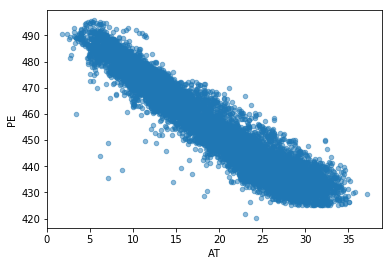

In [5]:
dataset.plot(kind = "scatter", x = "AT", y = "PE", alpha = 0.5)

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
print(scaler.fit_transform(dataset))
dataset = scaler.fit_transform(dataset)

[[-0.62951938 -0.98729659  1.8204884  -0.00951935  0.52120807]
 [ 0.74190911  0.68104512  1.1418628  -0.97462052 -0.58566442]
 [-1.95129733 -1.17301765 -0.18507756  1.2898397   2.00367889]
 ...
 [ 1.56583973  1.57581141 -0.05709854 -2.52261812 -1.45288056]
 [ 0.64797565  1.19177803  0.1011913  -0.74790051 -1.09134518]
 [ 0.26150656  0.64641916  0.66867722 -0.37254534 -0.06357687]]


In [15]:
%matplotlib inline
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

X, y = dataset[:, : 4] , dataset[: , 4]

X = torch.tensor(X)
y = torch.unsqueeze(torch.tensor(y), dim = 1)
print(X)
print(y)



tensor([[-0.6295, -0.9873,  1.8205, -0.0095],
        [ 0.7419,  0.6810,  1.1419, -0.9746],
        [-1.9513, -1.1730, -0.1851,  1.2898],
        ...,
        [ 1.5658,  1.5758, -0.0571, -2.5226],
        [ 0.6480,  1.1918,  0.1012, -0.7479],
        [ 0.2615,  0.6464,  0.6687, -0.3725]], dtype=torch.float64)
tensor([[ 0.5212],
        [-0.5857],
        [ 2.0037],
        ...,
        [-1.4529],
        [-1.0913],
        [-0.0636]], dtype=torch.float64)


In [16]:
torch.manual_seed(1) #reproducible                        

In [17]:
# n_hidden2, n_hidden3
class Net(torch.nn.Module):
    def __init__(self, n_features, n_hidden1, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_features, n_hidden1)
        self.hidden2 = torch.nn.Linear(n_hidden1, n_hidden2 )
        # self.hidden3 = torch.nn.Linear(n_hidden2, n_hidden3 )
        self.predict = torch.nn.Linear(n_hidden2, n_output )
        
    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        #x = F.relu(self.hidden3(x))
        x = self.predict(x)
        return x

In [20]:
n_features = 4
n_hidden1 = 100
n_hidden2 = 100
n_output = 1


net = Net(n_features, n_hidden1, n_hidden2, n_output)

print( net(X.float()))

tensor([[-0.1303],
        [-0.0959],
        [-0.1185],
        ...,
        [-0.0334],
        [-0.0260],
        [-0.0639]], grad_fn=<AddmmBackward>)


In [21]:
# Optimizer and loss function.
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1)
loss_func = torch.nn.MSELoss() # this is for regression mean squared loss

It is very important to use the right number of iterations for training otherwiser the model start overfitting.

In [26]:
from sklearn.metrics import accuracy_score

for epoch in range(100):
    
    # Forward propagation
    # Predictions based on the value of X_train
    prediction = net(X.float()) 
    # Computing and printing loss
    loss = loss_func(prediction, y.float())
    
    print('epoch : ', epoch, ' loss: ', loss.item())
    optimizer.zero_grad() # Clearing gradient for next train
    loss.backward()       # backpropagation, compute gradient
    optimizer.step()      # apply gradients